In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import allantools

import gm2
import trfp
import analysis_helper as helper

import plotting_functions as plt2

from IPython.display import clear_output

Welcome to JupyROOT 6.12/04


In [2]:
# %%time

# prefix = 'data2/newg2/DataProduction/Offline/ArtTFSDir/v9_32_00_dev/FieldPlainRootOutput_'
# interp_df = helper.root_to_pandas([8384], prefix=prefix, tr_run=True)

# for run in range(8385, 8424):
#     clear_output()
#     print 'Run: '+str(run)+' of 8423'
#     temp_df = helper.root_to_pandas([run], prefix=prefix, tr_run=True)
#     fill_times = np.arange(interp_df.index.values[-1]+1, temp_df.index.values[0])
#     fill_df = pd.DataFrame(index=fill_times, columns=interp_df.columns)

#     for col in interp_df.columns:
#         fill_df[col] = np.interp(fill_times, np.append(interp_df.index.values, temp_df.index.values),
#                                  np.append(interp_df[col].values, temp_df[col].values))

#     interp_df = interp_df.append(fill_df)
#     interp_df = interp_df.append(temp_df)

# interp_df['tr_phi'] = 14.063

# interp_df.to_hdf('hdf5/superlong_2.h5', 'tr_df')

interp_df = pd.read_hdf('hdf5/superlong_2.h5', 'tr_df')

In [3]:
moment_df = pd.DataFrame(index=interp_df.index)
moment_df['tr_phi'] = interp_df['tr_phi'].values

print 'Calculating trolley moments.',
theta_tr = trfp.THETA_TR
for m in np.arange(17):
    tr_probes = ['tr'+str(probe) for probe in np.arange(17)]
    moment_df['tr,m'+str(m+1)] = interp_df[tr_probes].dot(theta_tr[m])
    
for station in np.arange(72):
    print '\rCalculating station ' + str(station) + ' moments.',
    fp_st = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[station]]

    # choose proper theta matrix
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        if station == 41:
            theta_fp = trfp.THETA_FP_4_ST41
        elif (station == 37) | (station == 39):
            theta_fp = trfp.THETA_FP_4_ST37_ST39
        else:
            theta_fp = trfp.THETA_FP_4
    else:
        theta_fp = trfp.THETA_FP_6

    # step through m values
    for m in np.arange(len(trfp.STATION_PROBE_ID[station])):
        stm = 'st'+str(station)+',m'+str(m+1)
        moment_df[stm] = interp_df[fp_st].dot(theta_fp[m])
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        moment_df['st'+str(station)+',m5'] = np.nan
        moment_df['st'+str(station)+',m6'] = np.nan
        
# calculate baselines using the first 5 points (doesn't actually matter)
tr_baseline = np.empty((72,17))

df_mean =  np.mean(moment_df.iloc[0:1000], axis=0).values

for i in range(72):
    tr_baseline[i, :] = df_mean[1:18]
fp_baseline = np.reshape(df_mean[18:], (72,6))

baseline_time_1 = np.empty((72,6))
baseline_time_2 = np.empty((72,6))

baseline_time_1[:,:] = moment_df.index.values[0]
baseline_time_2[:,:] = moment_df.index.values[-1]

fp_df = moment_df.copy()

fp_df = fp_df.drop(columns=['tr_phi']+['tr,m'+str(m) for m in range(1,18)])

vtm_df = helper.vtm_calc(fp_df, baseline_time_1, baseline_time_2, tr_baseline, tr_baseline, fp_baseline, fp_baseline)

Calculating station 71 moments.                       


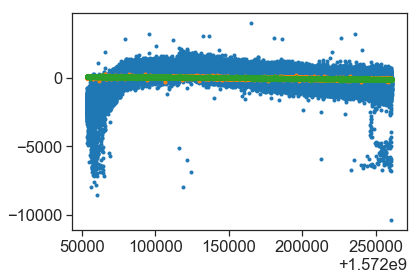

In [30]:
plt.plot(interp_df.index.values, interp_df['tr8'] - np.mean(interp_df['tr8']), '.')
plt.plot(interp_df.index.values, interp_df['tr9'] - np.mean(interp_df['tr9']), '.')
plt.plot(interp_df.index.values, interp_df['tr7'] - np.mean(interp_df['tr7']), '.')

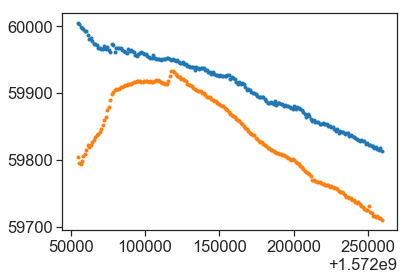

In [25]:
dt = 1000
start = np.ceil(vtm_df.index.values[0]/dt)*dt
end = np.floor(vtm_df.index.values[-1]/dt)*dt

bin_edges = np.arange(start, end+dt, dt)
bin_centers = np.arange(start, end, dt)+dt/2

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bin_edges)).mean()
vtm_bin_df.index = bin_centers

moment_bin_df = moment_df.groupby(pd.cut(moment_df.index, bin_edges)).mean()
moment_bin_df.index = bin_centers

plt.plot(vtm_bin_df.index.values, vtm_bin_df['st5,m1'] - 2.68 * vtm_bin_df['st5,m5'], '.')
plt.plot(vtm_bin_df.index.values, moment_bin_df['tr,m1'] + 9150, '.')

In [ ]:
plt.plot(moment_bin_df.index.values, moment_bin_df['st5,m1'] - vtm_bin_df['st5,m1'], '.')

[8.72828984e-01 6.57462415e+03]


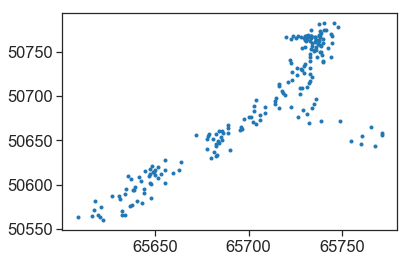

In [39]:
# plt.plot(vtm_bin_df['st5,m5'], moment_bin_df['st5,m1'] - vtm_bin_df['st5,m1'], '.')
plt.plot(vtm_bin_df['st5,m1'] - 2.68 * vtm_bin_df['st5,m5'] - 1.75 * vtm_bin_df['st5,m2'], moment_bin_df['tr,m1'], '.')

# p = np.polyfit(vtm_bin_df['st5,m5'].values, (moment_bin_df['st5,m1'] - vtm_bin_df['st5,m1']).values, 1)
p = np.polyfit(vtm_bin_df['st5,m1'].values, moment_bin_df['tr,m1'].values, 1)
print p

In [ ]:
(moment_bin_df.index.values[-1] - moment_bin_df.index.values[0])/3600

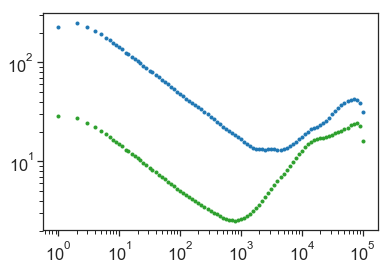

In [9]:
azi = trfp.STATION_BARCODE_PHI
weight_4 = (azi[6] - azi[5])/(azi[6] - azi[4])
weight_6 = (azi[5] - azi[4])/(azi[6] - azi[4])

taus_in = np.round(np.power(10, np.arange(0,6,0.05)))

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-(vtm_df['st5,m1']-0*vtm_df['st5,m5'])).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-weight_4*vtm_df['st4,m1']-weight_6*vtm_df['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st4,m1']-0.5*vtm_df['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-(vtm_df['st5,m1']-2.68*vtm_df['st5,m5'])).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.', color='C2')


In [11]:
56*3600/4

50400

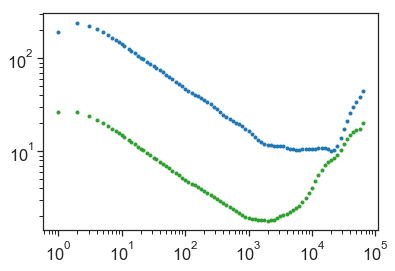

In [10]:
taus_in = np.round(np.power(10, np.arange(0,5.5,0.05)))

taus, adev, _, _ = allantools.ohdev((moment_df['tr,m1']-(vtm_df['st5,m1']-0*vtm_df['st5,m5'])).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.ohdev((moment_df['tr,m1']-weight_4*vtm_df['st4,m1']-weight_6*vtm_df['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st4,m1']-0.5*vtm_df['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.ohdev((moment_df['tr,m1']-(vtm_df['st5,m1']-2.68*vtm_df['st5,m5'])).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.', color='C2')

In [ ]:
plt.loglog(taus, adev_1-adev_2, '.')

print (adev_1-adev_2)[-1]

In [ ]:
taus_in = np.round(np.power(10, np.arange(0,5.5,0.05)))

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-vtm_df['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st4,m1']-0.5*vtm_df['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st2,m1']-0.5*vtm_df['st8,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st0,m1']-0.5*vtm_df['st10,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st70,m1']-0.5*vtm_df['st12,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

# taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st68,m1']-0.5*vtm_df['st14,m1']).values, data_type='freq', rate=1, taus=taus_in)
# plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st66,m1']-0.5*vtm_df['st16,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

In [ ]:
fps = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[5]]

for fp in fps:
    taus, adev, _, _ = allantools.oadev(interp_df[fp].values, data_type='freq', rate=1, taus=taus_in)
    plt.loglog(taus, adev, '.', label=fp)
plt.legend()

In [ ]:
fps = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[32]]

for fp in fps:
    taus, adev, _, _ = allantools.oadev(interp_df[fp].values, data_type='freq', rate=1, taus=taus_in)
    plt.loglog(taus, adev, '.', label=fp)
plt.legend()

In [ ]:
interp_df_2 = pd.read_hdf('hdf5/9day.h5', 'fp_df_1')

In [ ]:
fps = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[5]]

for fp in fps:
    taus, adev, _, _ = allantools.oadev(interp_df_2[fp].values, data_type='freq', rate=1, taus=taus_in)
    plt.loglog(taus, adev, '.', label=fp)
plt.legend()

In [ ]:
interp_df_3 = pd.read_hdf('hdf5/super-long_stationary_run.h5', 'interp_df')

In [ ]:
taus_in = np.round(np.power(10, np.arange(0,5.5,0.05)))

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-vtm_df['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st4,m1']-0.5*vtm_df['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

new_dipole = (interp_df['fp33'] + interp_df['fp34'] + interp_df['fp35'])/3

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-new_dipole).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

In [ ]:
new_m3 = 0.5*vtm_df['st4,m3'] + 0.5*vtm_df['st6,m3']
new_m3 = new_m3 - new_m3.values[0]

adjusted_m1 = new_dipole - new_m3*7.7/4.5

taus_in = np.round(np.power(10, np.arange(0,5,0.05)))

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-vtm_df['st5,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-0.5*vtm_df['st4,m1']-0.5*vtm_df['st6,m1']).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')

taus, adev, _, _ = allantools.oadev((moment_df['tr,m1']-adjusted_m1).values, data_type='freq', rate=1, taus=taus_in)
plt.loglog(taus, adev, '.')